In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x, noise, emp_var):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x) + noise * emp_var * torch.randn_like(emp_var))
        x = self.fc2(x)
        return F.log_softmax(x)

In [3]:
def train(network, optimizer, epoch, crpt_loader):
  network.train()
  for batch_idx, (data, target) in enumerate(crpt_loader):
    optimizer.zero_grad()
    output = network(data, 0, torch.zeros(1))
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(crpt_loader.dataset),
        100. * batch_idx / len(crpt_loader), loss.item()))

In [4]:
def test(network, noise, emp_var, crpt_loader):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in crpt_loader:
      output = network(data, noise, emp_var)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(crpt_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(crpt_loader.dataset),
    100. * correct / len(crpt_loader.dataset)))
  return 100. * correct / len(crpt_loader.dataset)

In [5]:
n_epochs = 640
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 500

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
def get_performance(crpt):
    perm_list = np.random.binomial(1, crpt, 60000)

    class crpt_MNIST(torchvision.datasets.MNIST):
        def __getitem__(self, index):
            img, target = super().__getitem__(index)

            if perm_list[index] == 1:
                target = np.random.randint(10)

            return img, target     

    crpt_loader = torch.utils.data.DataLoader(
        crpt_MNIST('./data', 
            train=True, 
            download=True,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.1307,), (0.3081,)
                )
            ]),
        ),
        batch_size=batch_size_train, 
        shuffle=True,
    )
    network = Net()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                        momentum=momentum)
    for epoch in range(5):
        train(network, optimizer, epoch, crpt_loader)
        test(network, 0., torch.zeros(1), crpt_loader)


    def get_var():
        network.eval()
        act = []
        with torch.no_grad():
            for data, target in crpt_loader:
                output = network.fc1(data.view(-1, 28*28))
            act.append(output)
        act = torch.cat(act, dim=0)
        return torch.std(act, dim=0)

    emp_var = get_var()
    lst = []
    for noise in 10. ** np.arange(-1., 1., .2):
        err = test(network, noise, emp_var, crpt_loader)
        lst.append(err)
        print(err)
    
    return lst

In [ ]:
lst_lst = []
for i in [0., .2, .4, .6, .8, 1.]:
    tmp = get_performance(i)
    print(tmp)
    lst_lst.append(tmp)

print(lst_lst)

with open("./fig2.pickle", "wb") as f:
    pickle.dump(lst_lst, f)

In [12]:
import pickle
with open("./log/fig2.pickle", "rb") as f:
    log = pickle.load(f)

In [14]:
log = [[ j.item() for j in i] for i in log]

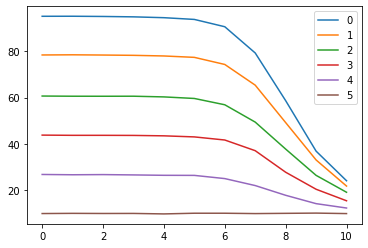

In [22]:
for idx, i in enumerate(log):
    plt.plot(i, label=idx)

plt.legend()
plt.show()

<ipython-input-35-9fae4b1d89d9>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


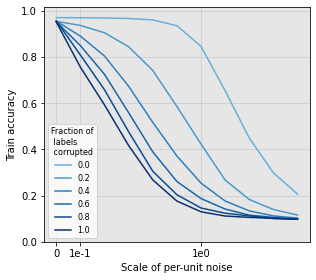

In [35]:
a = [96.99333190917969, 96.91166687011719, 96.8316650390625, 96.59666442871094, 95.98500061035156, 93.48833465576172, 84.5199966430664, 65.33499908447266, 44.89500045776367, 29.81999969482422, 20.65833282470703]
b = [95.37000274658203, 93.58333587646484, 90.43333435058594, 84.36166381835938, 74.11833190917969, 58.538333892822266, 42.28166580200195, 26.700000762939453, 18.30666732788086, 13.96833324432373, 11.576666831970215]
c = [95.49666595458984, 88.96666717529297, 80.38166809082031, 67.2750015258789, 51.663333892822266, 37.11833190917969, 25.395000457763672, 17.636667251586914, 13.375, 11.206666946411133, 10.265000343322754]
d = [95.23999786376953, 84.86499786376953, 72.42833709716797, 55.83833312988281, 38.90999984741211, 26.078332901000977, 18.709999084472656, 14.16333293914795, 11.553333282470703, 10.576666831970215, 9.806666374206543]
e = [95.54499816894531, 80.80500030517578, 65.7683334350586, 47.595001220703125, 30.530000686645508, 20.358333587646484, 14.616666793823242, 12.356666564941406, 11.21166706085205, 10.050000190734863, 9.763333320617676]
f = [95.08499908447266, 75.54166412353516, 59.185001373291016, 41.63166809082031, 26.768333435058594, 17.616666793823242, 12.988333702087402, 11.146666526794434, 10.561666488647461, 10.173333168029785, 9.765000343322754]
cmap = plt.get_cmap("Blues")
plt.plot(a, label = "0.0", color = cmap(0.5))
plt.plot(b, label = "0.2", color = cmap(0.6))
plt.plot(c, label = "0.4", color = cmap(0.7))
plt.plot(d, label = "0.6", color = cmap(0.8))
plt.plot(e, label = "0.8", color = cmap(0.9))
plt.plot(f, label = "1.0", color = cmap(1.0))
plt.legend(title="Fraction of\n labels\n corrupted", loc=3, fontsize=8, title_fontsize=8)
plt.rcParams["figure.figsize"] = (4.5, 4)
plt.grid(True, color=".8")
ax = plt.axes()
ax.set_facecolor(".9")
my_xticks = ['0','1e-1','1e0']
plt.xticks([0, 1, 6], my_xticks)
my_yticks = ['0.0','0.2','0.4', '0.6', '0.8', '1.0']
plt.yticks([0, 20, 40, 60, 80, 100], my_yticks)
plt.xlabel("Scale of per-unit noise")
plt.ylabel("Train accuracy")
plt.tight_layout()
plt.savefig("./log/feat_fig2_MNIST.jpg", dpi=400, transparent=False)

In [ ]:
lst = [[99.92833709716797, 99.92833709716797, 99.93000030517578, 99.91000366210938, 99.91666412353516, 99.913330078125, 99.87166595458984, 99.7750015258789, 99.36166381835938, 97.66000366210938, 91.5199966430664, 75.8933334350586, 53.13833236694336, 32.2216682434082, 20.6200008392334, 14.770000457763672, 11.561666488647461], [96.69000244140625, 96.66000366210938, 96.62833404541016, 96.57833099365234, 96.38833618164062, 95.80333709716797, 94.42333221435547, 90.83999633789062, 83.875, 72.65666961669922, 57.52333450317383, 40.73500061035156, 26.426666259765625, 17.530000686645508, 13.398333549499512, 11.518333435058594, 10.716666221618652], [95.38333129882812, 95.26667022705078, 95.19166564941406, 94.92333221435547, 94.23666381835938, 92.63833618164062, 88.4000015258789, 79.49666595458984, 66.03500366210938, 50.63166809082031, 36.34333419799805, 24.883333206176758, 17.2983341217041, 13.398333549499512, 11.100000381469727, 9.826666831970215, 8.739999771118164], [95.09666442871094, 95.0, 94.83000183105469, 94.40333557128906, 93.29666900634766, 90.73332977294922, 84.34500122070312, 72.67833709716797, 55.68333435058594, 39.20000076293945, 26.565000534057617, 18.65999984741211, 14.539999961853027, 11.828332901000977, 10.510000228881836, 10.016666412353516, 9.27833366394043], [95.44166564941406, 95.22666931152344, 94.97000122070312, 94.086669921875, 92.1433334350586, 87.7750015258789, 78.51333618164062, 62.746665954589844, 44.43000030517578, 28.796667098999023, 19.251667022705078, 14.069999694824219, 11.72166633605957, 10.758333206176758, 10.055000305175781, 9.25333309173584, 8.574999809265137], [95.16000366210938, 94.93499755859375, 94.38999938964844, 93.336669921875, 90.90499877929688, 84.95500183105469, 74.3550033569336, 58.11166763305664, 40.4466667175293, 25.748332977294922, 16.95833396911621, 12.850000381469727, 11.024999618530273, 10.236666679382324, 10.196666717529297, 9.838333129882812, 9.526666641235352]]

for i, llst in enumerate(lst):
    plt.plot(llst, label = "0.{}".format(2*i), color = cmap(0.5 + 0.1 * i))

plt.legend()
my_xticks = ['0','1e-2','1e-1', '1e0', '1e1']
plt.xticks([0, 1, 6, 11, 16], my_xticks)
plt.xlabel("Scale of per-unit noise")
plt.ylabel("Train accuracy")
plt.show()

In [ ]:
lst = [[99.92833709716797, 99.92833709716797, 99.93000030517578, 99.91000366210938, 99.91666412353516, 99.913330078125, 99.87166595458984, 99.7750015258789, 99.36166381835938, 97.66000366210938, 91.5199966430664, 75.8933334350586, 53.13833236694336, 32.2216682434082, 20.6200008392334, 14.770000457763672, 11.561666488647461], [97.3316650390625, 97.2933349609375, 97.2750015258789, 97.21833038330078, 97.00333404541016, 96.66000366210938, 95.33000183105469, 91.85333251953125, 84.95166778564453, 73.64167022705078, 58.1783332824707, 41.23666763305664, 26.866666793823242, 18.046667098999023, 13.28833293914795, 11.526666641235352, 9.956666946411133], [97.28333282470703, 97.21499633789062, 97.08999633789062, 96.87166595458984, 96.28333282470703, 94.67500305175781, 90.58000183105469, 81.91666412353516, 68.44499969482422, 52.516666412353516, 38.35333251953125, 26.030000686645508, 17.96666717529297, 12.953332901000977, 10.40999984741211, 9.420000076293945, 8.49666690826416], [97.07666778564453, 96.9749984741211, 96.80000305175781, 96.45333099365234, 95.29166412353516, 92.52166748046875, 86.0250015258789, 73.5633316040039, 56.244998931884766, 39.67333221435547, 27.22166633605957, 18.889999389648438, 14.201666831970215, 11.555000305175781, 10.551666259765625, 9.076666831970215, 8.576666831970215], [97.19000244140625, 97.0, 96.7683334350586, 96.01667022705078, 94.21833038330078, 90.0433349609375, 81.0250015258789, 65.55333709716797, 46.348331451416016, 30.356666564941406, 19.725000381469727, 14.539999961853027, 11.761666297912598, 10.898333549499512, 10.069999694824219, 9.568333625793457, 9.073333740234375], [97.0633316040039, 96.77833557128906, 96.35166931152344, 95.23332977294922, 92.70500183105469, 86.89666748046875, 75.49666595458984, 59.23833465576172, 40.53333282470703, 26.038333892822266, 17.114999771118164, 12.585000038146973, 10.941666603088379, 10.194999694824219, 10.100000381469727, 10.050000190734863, 9.78499984741211]]
for i, llst in enumerate(lst):
    plt.plot(llst, label = "0.{}".format(2*i), color = cmap(0.5 + 0.1 * i))

plt.legend()
my_xticks = ['0','1e-2','1e-1', '1e0', '1e1']
plt.xticks([0, 1, 6, 11, 16], my_xticks)
plt.xlabel("Scale of per-unit noise")
plt.ylabel("Train accuracy")
plt.show()

<ipython-input-36-594795f3e451>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


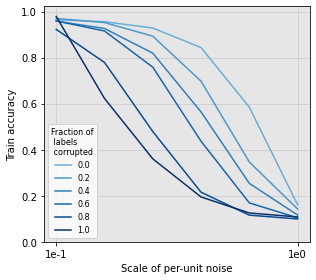

In [36]:
import matplotlib.pyplot as plt
a = [97.04000091552734, 97.03199768066406, 97.04199981689453, 97.02200317382812, 97.04000091552734, 96.87799835205078, 96.45800018310547, 95.59600067138672, 92.85399627685547, 84.37999725341797, 58.487998962402344, 16.121999740600586, 10.022000312805176, 10.0, 10.0, 10.0, 10.0]
b = [97.76799774169922, 97.76200103759766, 97.75800323486328, 97.69400024414062, 97.66799926757812, 97.48799896240234, 97.0, 95.21199798583984, 89.31800079345703, 69.76799774169922, 34.69599914550781, 14.263999938964844, 10.104000091552734, 9.928000450134277, 10.071999549865723, 10.13599967956543, 9.788000106811523]
c = [97.31400299072266, 97.29000091552734, 97.23400115966797, 97.1760025024414, 97.10600280761719, 96.71800231933594, 95.8280029296875, 92.6520004272461, 81.93800354003906, 56.4119987487793, 25.398000717163086, 11.628000259399414, 10.086000442504883, 9.970000267028809, 9.907999992370605, 9.807999610900879, 9.973999977111816]
d = [97.63999938964844, 97.6500015258789, 97.64600372314453, 97.60600280761719, 97.40399932861328, 97.16200256347656, 95.93199920654297, 91.55599975585938, 75.85199737548828, 43.6879997253418, 16.898000717163086, 10.42199993133545, 10.074000358581543, 9.954000473022461, 10.01200008392334, 10.0, 10.184000015258789]
e = [97.22000122070312, 97.19599914550781, 97.13999938964844, 97.12200164794922, 96.80799865722656, 95.93599700927734, 92.24600219726562, 77.89800262451172, 47.88999938964844, 21.552000045776367, 11.574000358581543, 9.923999786376953, 10.253999710083008, 10.076000213623047, 10.208000183105469, 10.166000366210938, 10.246000289916992]
f = [97.8479995727539, 74.38200378417969, 62.24599838256836, 49.124000549316406, 36.04800033569336, 26.29400062561035, 19.47800064086914, 15.246000289916992, 12.520000457763672, 11.4399995803833, 10.784000396728516]

cmap = plt.get_cmap("Blues")
plt.plot(a[6:12], label = "0.0", color = cmap(0.5))
plt.plot(b[6:12], label = "0.2", color = cmap(0.6))
plt.plot(c[6:12], label = "0.4", color = cmap(0.7))
plt.plot(d[6:12], label = "0.6", color = cmap(0.8))
plt.plot(e[6:12], label = "0.8", color = cmap(0.9))
plt.plot(np.array(f)[::2], label = "1.0", color = cmap(1.0))
plt.legend(title="Fraction of\n labels\n corrupted", loc=3, fontsize=8, title_fontsize=8)
plt.rcParams["figure.figsize"] = (4.5, 4)
plt.grid(True, color=".8")
ax = plt.axes()
ax.set_facecolor(".9")
my_xticks = ['1e-1', '1e0']
plt.xticks([0, 5], my_xticks)
my_yticks = ['0.0','0.2','0.4', '0.6', '0.8', '1.0']
plt.yticks([0, 20, 40, 60, 80, 100], my_yticks)
plt.xlabel("Scale of per-unit noise")
plt.ylabel("Train accuracy")
plt.tight_layout()
plt.savefig("./log/feat_fig2_CIFAR.jpg", dpi=400, transparent=False)

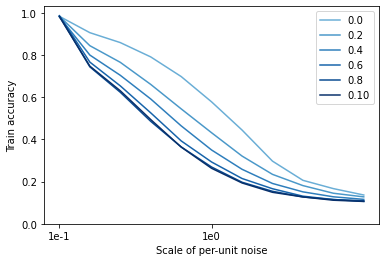

In [16]:
lst = [[98.26200103759766, 90.5199966430664, 85.82599639892578, 79.04399871826172, 69.74800109863281, 57.74599838256836, 44.41600036621094, 29.68199920654297, 20.5939998626709, 16.667999267578125, 13.63599967956543], [98.31800079345703, 84.36199951171875, 76.47599792480469, 66.02200317382812, 54.439998626708984, 43.119998931884766, 32.0880012512207, 23.417999267578125, 18.0939998626709, 14.472000122070312, 12.755999565124512], [98.00599670410156, 79.91999816894531, 70.33599853515625, 59.11800003051758, 46.391998291015625, 34.95000076293945, 25.81999969482422, 19.104000091552734, 15.128000259399414, 12.788000106811523, 11.571999549865723], [98.58599853515625, 76.58399963378906, 65.3280029296875, 52.54600143432617, 39.27399826049805, 29.26799964904785, 21.45400047302246, 16.610000610351562, 13.088000297546387, 11.498000144958496, 10.628000259399414], [98.33200073242188, 74.3280029296875, 62.29600143432617, 48.53200149536133, 36.42399978637695, 26.88800048828125, 19.694000244140625, 15.392000198364258, 12.72599983215332, 11.473999977111816, 10.913999557495117], [98.11599731445312, 74.68000030517578, 63.00400161743164, 49.37200164794922, 36.34400177001953, 26.277999877929688, 19.34000015258789, 14.916000366210938, 12.723999977111816, 11.168000221252441, 10.586000442504883]]
for i, llst in enumerate(lst):
    plt.plot(llst, label = "0.{}".format(2*i), color = cmap(0.5 + 0.1 * i))

plt.legend()
my_xticks = ['1e-1', '1e0']
plt.xticks([0, 5], my_xticks)
my_yticks = ['0.0','0.2','0.4', '0.6', '0.8', '1.0']
plt.yticks([0, 20, 40, 60, 80, 100], my_yticks)
plt.xlabel("Scale of per-unit noise")
plt.ylabel("Train accuracy")
plt.show()